Analysis of Unrestrained Fully Coupled Trajectory to Generate Parameters for Multiple Distance Restraints

In [1]:
import MDAnalysis as mda
from MDAnalysis.analysis.distances import dist
from MDAnalysis.lib.distances import calc_dihedrals
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [2]:
# FIXME: Replace with paths to your own trajectory and topology files
u = mda.Universe('flip/5ag5_prot-7-neutralized.psf', 'flip/5ag5_prot-7-equil.dcd')


lig_heavy = u.select_atoms("resname XRAY or resname REVR or resname LIG and not name H*")

# anchors dict of dict. For each ligand heavy atom there is a dictionary of protein heavy atoms,
# for each of which there is a dictionary of average distance and standard deviation

anchors_dict = {}
for lig_atom in lig_heavy:
    for prot_atom in u.select_atoms(f"(protein or segid PROT) and (around 10 index {lig_atom.index}) and (not name H*)"): # protein does not recognise PRT
        anchors_dict[(lig_atom.index,prot_atom.index)]={}
        anchors_dict[(lig_atom.index, prot_atom.index)]["dists"]=[]

/Home/ii/parveeng/miniconda3/envs/offtk/lib/python3.10/site-packages/MDAnalysis/coordinates/DCD.py:165: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [3]:
#anchors_dict

Compute average distances and SD

In [4]:
u.transfer_to_memory()

In [4]:
for frame in u.trajectory:
    for lig_atom_index, prot_atom_index in anchors_dict.keys():
        distance = dist(mda.AtomGroup([u.atoms[lig_atom_index]]), mda.AtomGroup([u.atoms[prot_atom_index]]), box=frame.dimensions)[2][0]
        anchors_dict[(lig_atom_index,prot_atom_index)]["dists"].append(distance)

In [6]:
#anchors_dict

In [5]:
# change lists to numpy arrays
for pair in anchors_dict.keys():
    anchors_dict[pair]["dists"] = np.array(anchors_dict[pair]["dists"])

In [6]:
# calculate average and SD
for pair in anchors_dict.keys():
    anchors_dict[pair]["avg_dist"] = anchors_dict[pair]["dists"].mean()
    anchors_dict[pair]["sd_dist"] = anchors_dict[pair]["dists"].std()


In [7]:
# get n pairs with lowest SD
pairs_ordered_sd=[]
for item in sorted(anchors_dict.items(), key=lambda item: item[1]["sd_dist"]):
    pairs_ordered_sd.append(item[0])
    print(f'Pair: {item[0]}, av distance: {item[1]["avg_dist"]:.2f}, SD: {item[1]["sd_dist"]:.2f}')

Pair: (6673, 5178), av distance: 3.38, SD: 0.20
Pair: (6673, 5181), av distance: 2.78, SD: 0.21
Pair: (6665, 5178), av distance: 4.48, SD: 0.21
Pair: (6673, 5174), av distance: 5.54, SD: 0.23
Pair: (6665, 5174), av distance: 6.64, SD: 0.24
Pair: (6665, 1187), av distance: 3.83, SD: 0.24
Pair: (6665, 5181), av distance: 3.74, SD: 0.24
Pair: (6665, 1181), av distance: 7.08, SD: 0.24
Pair: (6673, 5164), av distance: 7.50, SD: 0.25
Pair: (6665, 1183), av distance: 5.88, SD: 0.25
Pair: (6665, 5164), av distance: 8.50, SD: 0.25
Pair: (6665, 1168), av distance: 8.18, SD: 0.26
Pair: (6665, 1182), av distance: 7.48, SD: 0.26
Pair: (6674, 5174), av distance: 9.22, SD: 0.26
Pair: (6674, 5178), av distance: 7.03, SD: 0.26
Pair: (6673, 5172), av distance: 6.19, SD: 0.26
Pair: (6665, 1185), av distance: 4.82, SD: 0.27
Pair: (6665, 5160), av distance: 8.86, SD: 0.27
Pair: (6665, 5172), av distance: 7.23, SD: 0.27
Pair: (6673, 5166), av distance: 8.68, SD: 0.27
Pair: (6674, 5176), av distance: 8.19, S

In [8]:
# Print out pairs with lowest SD
print("The ligand-protein atom pairs with the lowest SD in distance are:")
for i in range(10):
    print(f"{u.atoms[pairs_ordered_sd[i][0]]} and {u.atoms[pairs_ordered_sd[i][1]]}")

The ligand-protein atom pairs with the lowest SD in distance are:
<Atom 6674: O1 of type OG2D1 of resname REVR, resid 1 and segid REVR> and <Atom 5179: CB of type CT2 of resname SER, resid 330 and segid PROT>
<Atom 6674: O1 of type OG2D1 of resname REVR, resid 1 and segid REVR> and <Atom 5182: OG of type OH1 of resname SER, resid 330 and segid PROT>
<Atom 6666: C10 of type CG2R53 of resname REVR, resid 1 and segid REVR> and <Atom 5179: CB of type CT2 of resname SER, resid 330 and segid PROT>
<Atom 6674: O1 of type OG2D1 of resname REVR, resid 1 and segid REVR> and <Atom 5175: N of type NH1 of resname SER, resid 330 and segid PROT>
<Atom 6666: C10 of type CG2R53 of resname REVR, resid 1 and segid REVR> and <Atom 5175: N of type NH1 of resname SER, resid 330 and segid PROT>
<Atom 6666: C10 of type CG2R53 of resname REVR, resid 1 and segid REVR> and <Atom 1188: CB of type CT2 of resname PHE, resid 88 and segid PROT>
<Atom 6666: C10 of type CG2R53 of resname REVR, resid 1 and segid REVR> a

In [9]:
# print out indices of top 20 ligand atoms
lig_anchors = []

for i in range(20):
    print(pairs_ordered_sd[i][0], end=' ')
    lig_anchors.append(pairs_ordered_sd[i][0])
    
print(f"\n\nThe number of unique ligand anchors is: {len(set(lig_anchors))}")

6673 6673 6665 6673 6665 6665 6665 6665 6673 6665 6665 6665 6665 6674 6674 6673 6665 6665 6665 6673 

The number of unique ligand anchors is: 3


Ensure no Duplicated Atoms in Restraints

In [10]:
unique_pairs_ordered_sd = []
lig_ats = []
recept_ats = []

for pair in pairs_ordered_sd:
    if pair[0] not in lig_ats:
        if pair[1] not in recept_ats:
            unique_pairs_ordered_sd.append(pair)
            lig_ats.append(pair[0])
            recept_ats.append(pair[1])
            if len(unique_pairs_ordered_sd) == 22:
                break

In [11]:
# print out indices of anchor atoms in top 20 pairs

for i in range(20):
    print(unique_pairs_ordered_sd[i][0], unique_pairs_ordered_sd[i][1], end=' ')
    #print(anchors_dict[unique_pairs_ordered_sd[i]]["sd_dist"])


6673 5178 6665 5174 6674 5176 6662 5183 6672 5158 6668 1185 6646 1187 6671 1201 6669 1183 6652 1203 6660 1117 6648 1190 6666 1119 6667 1094 6656 1092 6658 1202 6675 5341 6650 1234 6654 1199 6676 3422 

In [12]:
def get_distance(idx1, idx2, u):
    """ Distance in Angstrom"""
    distance = dist(mda.AtomGroup([u.atoms[idx1]]), mda.AtomGroup([u.atoms[idx2]]), box=u.dimensions)[2][0]
    return distance

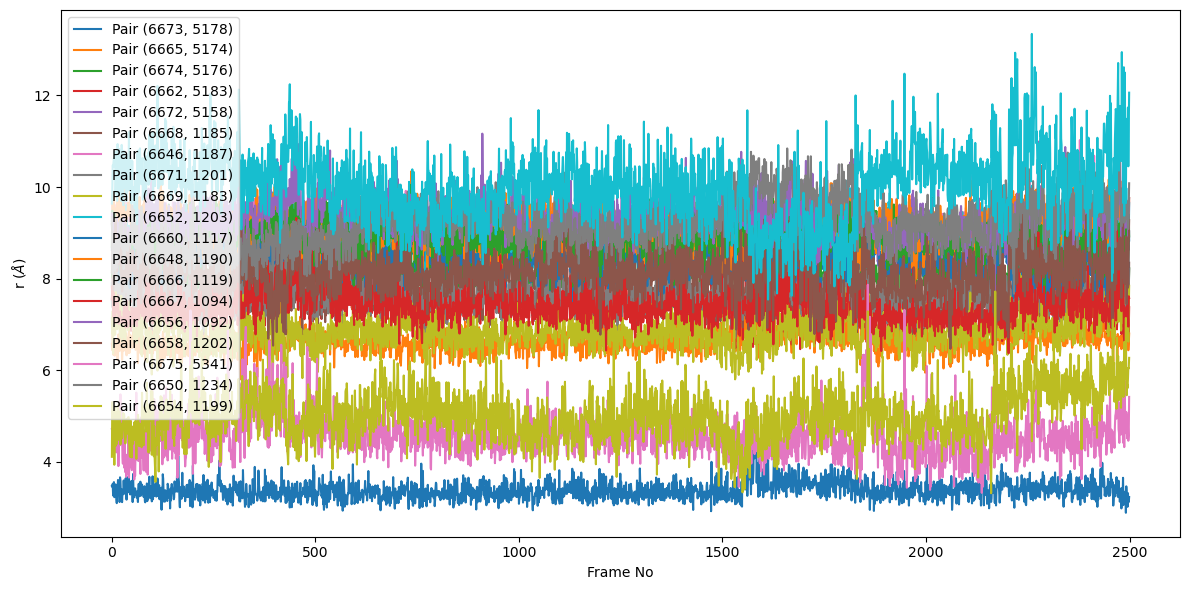

In [20]:
num_pairs = round(len(unique_pairs_ordered_sd))

frames = u.trajectory.n_frames

fig, ax = plt.subplots(1,1, figsize=(12,6))
for i, pair in enumerate(unique_pairs_ordered_sd):
    if i > -1:
        ax.plot([x for x in range(frames)], anchors_dict[pair]["dists"],label=f"Pair {pair}")
        ax.set_ylabel("r ($\AA$)")
        if i == num_pairs-1:
            break
    ax.set_xlabel("Frame No")
    ax.legend()
fig.tight_layout()


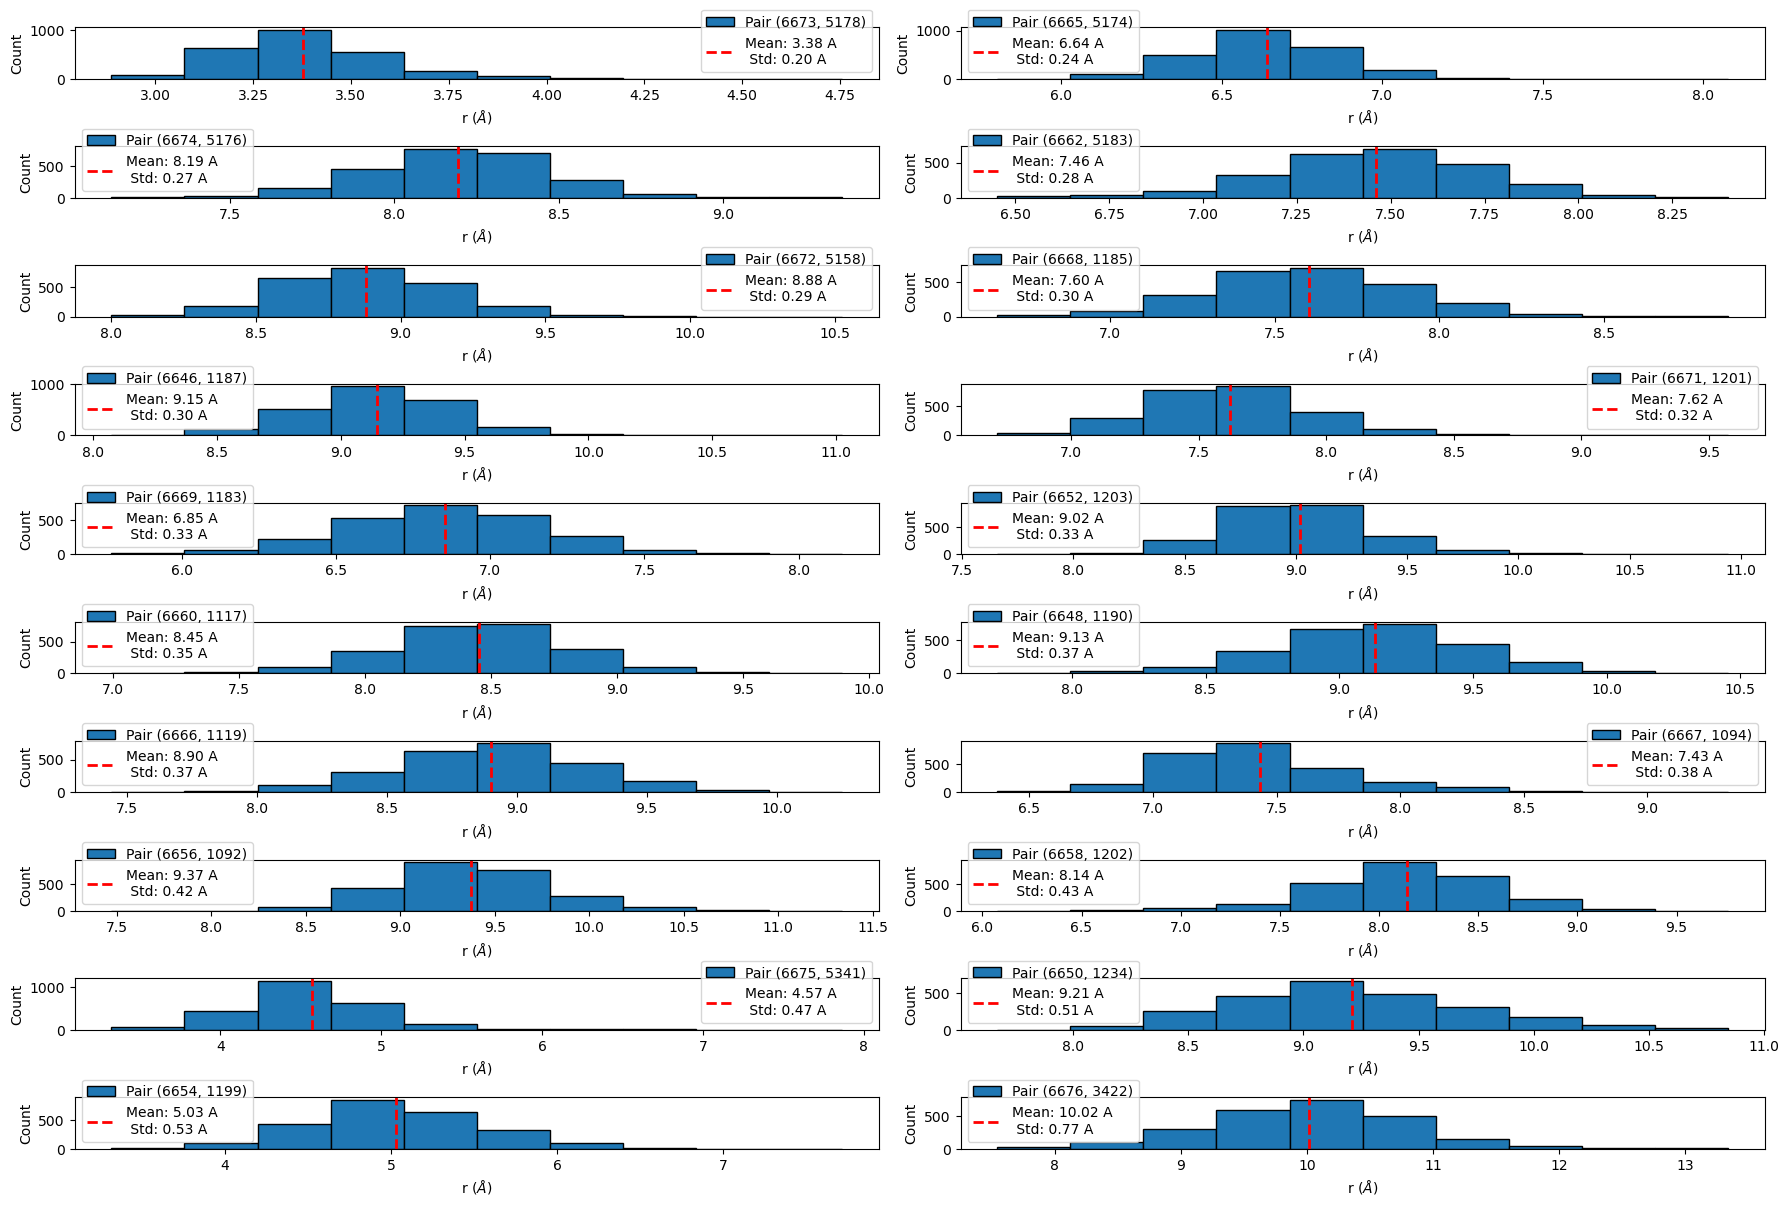

In [14]:
# Plot histograms

rows = round(len(unique_pairs_ordered_sd) / 2)

fig, axs = plt.subplots(rows, 2, figsize=(18,6*(len(unique_pairs_ordered_sd)%6)))
axs = axs.flatten()
for i, pair in enumerate(unique_pairs_ordered_sd):
    axs[i].hist(anchors_dict[pair]["dists"],label=f"Pair {pair}", edgecolor='k')
    axs[i].axvline(anchors_dict[pair]["avg_dist"], color='r', linestyle = "dashed", linewidth=2, label=f'Mean: {anchors_dict[pair]["avg_dist"]:.2f} A\n Std: {anchors_dict[pair]["sd_dist"]:.2f} A')
    axs[i].set_xlabel("r ($\AA$)")
    axs[i].set_ylabel("Count")
    axs[i].legend()
fig.tight_layout()

Generate Restraints by Assuming Gaussian Distributions

In [15]:
# Select flat-bottomed region to contain 95 % of the probability density from test simulation, then set high force constants
# for the half-harmonic potentials
# Form of restraints: restraints = { (i0, i1): (r01, kl, Dl), (i0,i2): (r02, kl, Dl) }

restraints = {}
## Atom indices starts from 0 in mdAnalysis

for pair in unique_pairs_ordered_sd:
    r0 = round(anchors_dict[pair]["avg_dist"],2) # A
    kl = 40 # kcal/(mol * A**2)
    dl = 0.4
    restraints[pair] = (r0, kl, dl)
    #print(pair[0], pair[1], restraints[pair][0])
    #print(f"{u.atoms[pair[0]]} and {u.atoms[pair[1]]}")
    lig = u.atoms[pair[0]]
    prot = u.atoms[pair[1]]
    print(f'assign sele atom {prot.segid} {prot.resid} {prot.name} end sele atom {lig.segid} {lig.resid} {lig.name} end -')
    print(f'kmin {kl} rmin {round(r0-dl,1)} kmax {kl} rmax {round(r0+dl,1)} fmax 0.0')
    print('')


#print(restraints)

assign sele atom PROT 330 CB end sele atom REVR 1 O1 end -
kmin 40 rmin 3.0 kmax 40 rmax 3.8 fmax 0.0

assign sele atom PROT 330 N end sele atom REVR 1 C10 end -
kmin 40 rmin 6.2 kmax 40 rmax 7.0 fmax 0.0

assign sele atom PROT 330 CA end sele atom REVR 1 S1 end -
kmin 40 rmin 7.8 kmax 40 rmax 8.6 fmax 0.0

assign sele atom PROT 330 C end sele atom REVR 1 C9 end -
kmin 40 rmin 7.1 kmax 40 rmax 7.9 fmax 0.0

assign sele atom PROT 328 C end sele atom REVR 1 N2 end -
kmin 40 rmin 8.5 kmax 40 rmax 9.3 fmax 0.0

assign sele atom PROT 88 CA end sele atom REVR 1 C13 end -
kmin 40 rmin 7.2 kmax 40 rmax 8.0 fmax 0.0

assign sele atom PROT 88 CB end sele atom REVR 1 C1 end -
kmin 40 rmin 8.8 kmax 40 rmax 9.6 fmax 0.0

assign sele atom PROT 88 C end sele atom REVR 1 N1 end -
kmin 40 rmin 7.2 kmax 40 rmax 8.0 fmax 0.0

assign sele atom PROT 88 N end sele atom REVR 1 C14 end -
kmin 40 rmin 6.4 kmax 40 rmax 7.2 fmax 0.0

assign sele atom PROT 89 N end sele atom REVR 1 C4 end -
kmin 40 rmin 8.6 kmax 

Free energy associated with the restraints
  

In [16]:
import numpy as np
import os
from math import pi, sin, log
import scipy.integrate

'''
NOE
       /  0.5*KMIN*(RAVE-RMIN)**2    R<RMIN
      /
     /    0.0                        RMIN<R<RMAX
E(R)=
     \    0.5*KMAX*(RAVE-RMAX)**2    RMAX<RAVE<RLIM
      \
       \  FMAX*(RAVE-(RLIM+RMAX)/2)  RAVE>RLIM


FMAX = 0.0
RSWITch - not using
SEXP - not using
RAVE = R ; no TCON specified in input
NOE inputs:
kmin = kmax = kr
rmin = r0 - r_fb
rmax = r0 + r_fb

r_fb = 0.4 (let's start with this)

original reference:
r0 =  (rmin + rmax ) / 2
r_fb =  rmax - r0 ## The radius of the flat-bottomed region was selected to be as small as possible
kr = kmin or kmax based on r
'''

# Constants
v0 = 1661 # A^3, the standard state volume
T = 298.15 # K
R = 0.0019872041 ## it should be Boltzmann's constant #unit: kcal/(mol*K), wrong => # kcal mol-1, the molar gas constant

In [17]:
def numerical_distance_integrand(r, r0, r_fb, kr):
    """Integrand for harmonic distance restraint. Domain is on [0, infinity], 
    but this will be truncated to [0, 8 RT] for practicality.

    Args:
        r (float): Distance to be integrated, in Angstrom 
        r0 (float): Equilibrium distance, in Angstrom
        r_fb (float): Flat-bottomed radius, in Angstrom
        kr (float): Force constant, in kcal mol-1 A-2

    Returns:
        float: Value of integrand
    """
    r_eff = abs(r - r0) - r_fb
    if r_eff < 0:
        r_eff = 0
    return (r**2)*np.exp(-(kr*r_eff**2)/(2*R*T))

def get_correction(r0, r_fb, kr):
    """Get the free energy of releasing the harmonic distance restraint.
    Domain is on [0, infinity], but this will be truncated to [0, 8 RT] for practicality.
    Args:
        r0 (float): Equilibrium distance, in Angstrom
        r_fb (float): Flat-bottomed radius, in Angstrom
        kr (float): Force constant, in kcal mol-1 A-2
    Returns:
        float: Free energy of releasing the restraint
    """
    dist_at_8RT = 4*np.sqrt((R*T)/kr) + r_fb #fb_radius # Dist. which gives restraint energy = 8 RT
    r_min = max(0, r0-dist_at_8RT)
    r_max = r0 + dist_at_8RT
    integrand = lambda r: numerical_distance_integrand(r, r0, r_fb, kr)
    z_r = scipy.integrate.quad(integrand, r_min, r_max)[0]
    dg = -R*T*log(v0/(4*np.pi*z_r))

    return dg

In [18]:
DG = []
for pair in unique_pairs_ordered_sd:
    r0 = round(anchors_dict[pair]["avg_dist"],2) # A
    cor = get_correction(r0, 0.4, 40)
    DG.append(cor)
    print(f"Free energy of releasing flat-bottomed restraint: {cor:.2f} kcal mol-1")

print(f'Total Free energy of releasing all the restraints: {sum(DG):.2f} kcal/mol')

Free energy of releasing flat-bottomed restraint: -1.39 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.59 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.34 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.45 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.25 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.43 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.21 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.43 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.55 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.23 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.30 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.21 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.24 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.46 kcal mol-1
Free energy of releasing flat-bottomed restraint: -0.18 kcal m